"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [8]:
# Some poisson spiking
length = 100
states = 2
nrns = 10
tastes = 4
trials = 20
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

print(true_tau.shape)

(4, 20, 2)


In [9]:
state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

print(true_tau.shape)
print(state_inds.shape)

(4, 19, 2)
(4, 20, 3)


In [10]:
true_lambda = np.random.random((tastes,nrns,states))
print(true_lambda.shape)

(4, 10, 2)


In [15]:
true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r        


In [116]:
print(data_array.shape)
true_r_long = np.reshape(true_r, (-1,*true_r.shape[2:]))
data_array_long = np.reshape(data_array, (-1,*data_array.shape[2:]))
print(data_array_long.shape)
taste_labels = np.repeat(np.arange(tastes),trials)
print(taste_labels)

(4, 20, 10, 100)
(80, 10, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


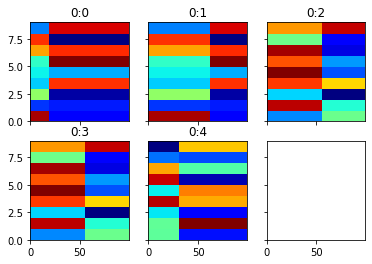

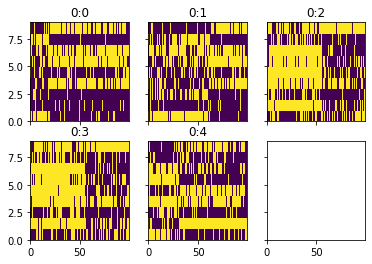

In [20]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials*tastes),5)
visualize.firing_overview(true_r_long[trial_inds]);
visualize.firing_overview(data_array_long[trial_inds], cmap='viridis');

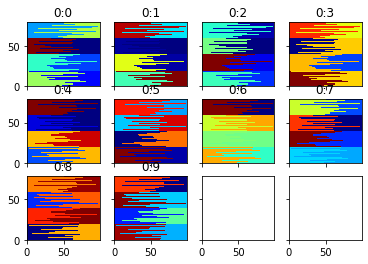

In [22]:
visualize.firing_overview(true_r_long.swapaxes(0,1));

(4, 10, 2)


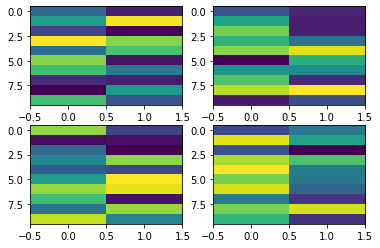

In [84]:
mean_vals = np.mean(np.array(np.array_split(data_array,states,axis=-1)),axis=(-1,2)).T.swapaxes(0,1)
print(mean_vals.shape)

fig,ax = visualize.gen_square_subplots(mean_vals.shape[0])
for this_dat, this_ax in zip(mean_vals, ax.flatten()):
    this_ax.imshow(this_dat,aspect='auto')

In [85]:
with pm.Model() as model:
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (tastes,nrns,states),
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (tastes*trials,states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [86]:
print(tau.tag.test_value.shape)
print(idx.shape)

(80, 1)
(100,)


In [87]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((tastes*trials,1,length)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((tastes*trials,1,length))],axis=1)

    weight_stack = np.multiply(weight_stack,inverse_stack)

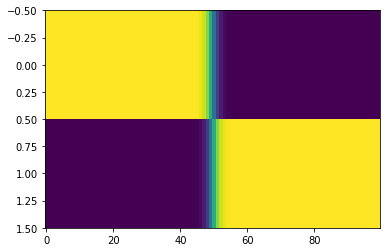

In [88]:
plt.imshow(weight_stack.tag.test_value[0],aspect='auto');

In [118]:
print(lambda_latent.tag.test_value.shape)
print(weight_stack.tag.test_value.shape) # Positions of changepoint
print(lambda_latent.tag.test_value[taste_labels].shape)

(4, 10, 2)
(80, 2, 100)
(80, 10, 2)


In [122]:
print(np.tile(weight_stack.tag.test_value[:,:,np.newaxis], (1,1,nrns,1)).shape)
print(np.tile(lambda_latent.tag.test_value[taste_labels].swapaxes(1,2)[:,:,:,np.newaxis], (1,1,1,length)).shape)

(80, 2, 10, 100)
(80, 2, 10, 100)


In [125]:
np.multiply(
        np.tile(weight_stack.tag.test_value[:,:,np.newaxis], (1,1,nrns,1)),
np.tile(lambda_latent.tag.test_value[taste_labels].swapaxes(1,2)[:,:,:,np.newaxis], (1,1,1,length))).shape

(80, 2, 10, 100)

In [123]:
with model:
    lambda_ = np.multiply(
                    np.tile(weight_stack[:,:,np.newaxis], (1,1,nrns,1)), 
                    np.tile(lambda_latent[taste_labels].swapaxes(1,2)[:,:,:,np.newaxis], (1,1,1,length)))
print(lambda_.tag.test_value.shape)
print(data_array_long.shape)

ValueError: ('You cannot drop a non-broadcastable dimension.', ([False, False, False], [0, 1, 'x']))

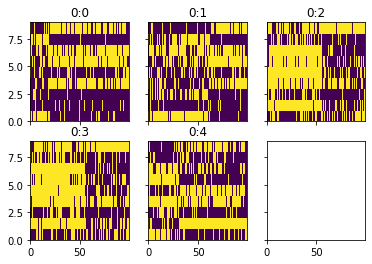

<Figure size 432x288 with 0 Axes>

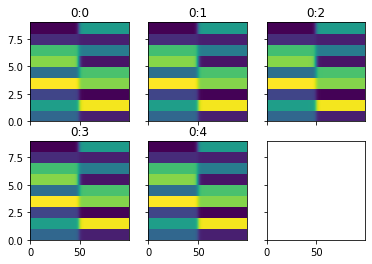

In [91]:
visualize.firing_overview(data_array_long[trial_inds],cmap='viridis');
plt.figure()
visualize.firing_overview(lambda_.tag.test_value[trial_inds], cmap='viridis');

In [69]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_array_long)

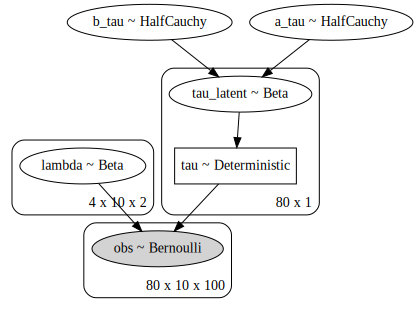

In [70]:
pm.model_to_graphviz(model)

In [71]:
with model:
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=fit, method=inference,
                   random_seed = 3,
                   obj_n_mc = 1)
    trace = approx.sample(draws=samples)

  0%|          | 0/100000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 61,100:   1%|          | 665/100000 [00:05<13:43, 120.61it/s] 
Interrupted at 677 [0%]: Average Loss = 60,207


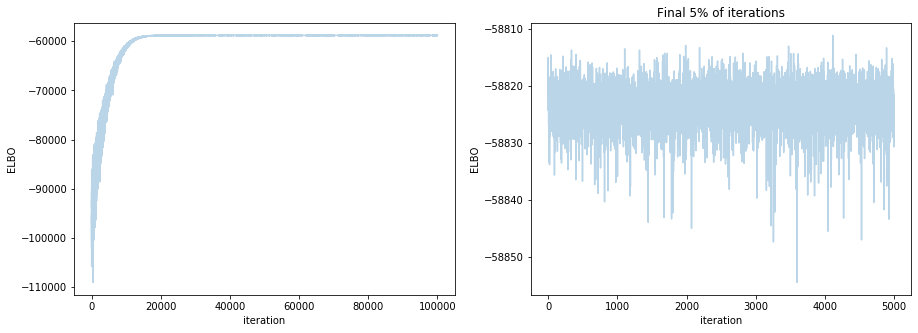

In [156]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [157]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

100%|██████████| 2000/2000 [00:23<00:00, 84.80it/s]


In [158]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials),5)

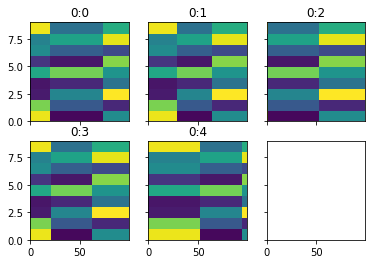

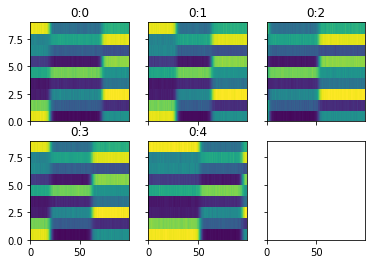

In [159]:
visualize.firing_overview(true_r[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [160]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

(2000, 120, 2)
(120, 2)


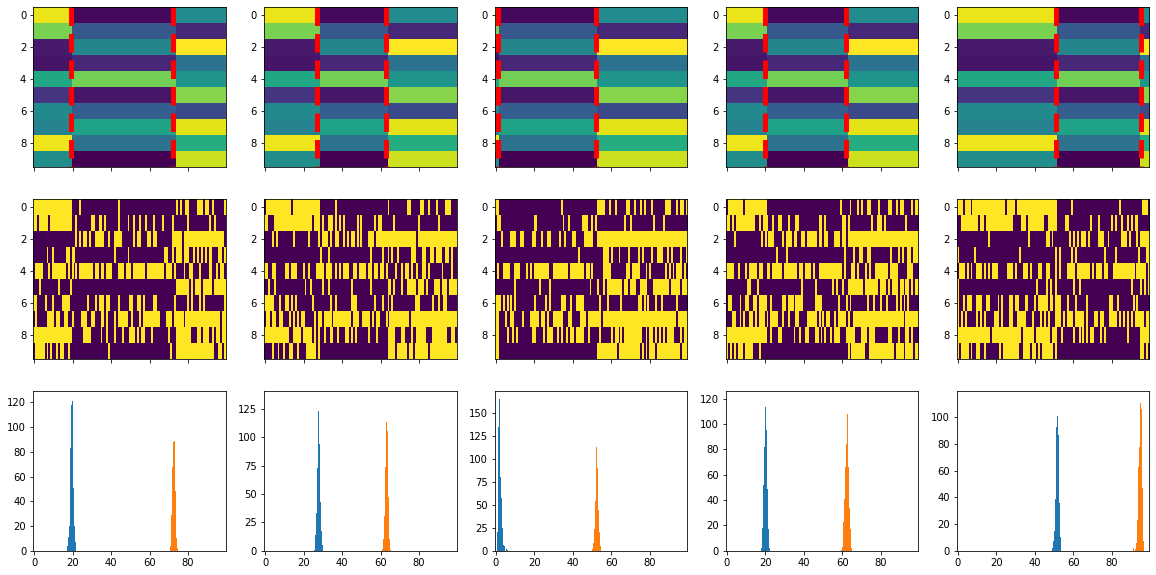

In [163]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(true_r[this_trial_ind],aspect='auto')
    ax[1,trial_num].imshow(data_array[this_trial_ind],aspect='auto')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')